# Supervised Learning
The idea of this notebook is using different learning machines in order to see how good are timbral features to describe musical genres. 
The data used is extracted from the GTZAN dataset: mfcc using gaussian windows with 60% overlapping. The features are the mean of the mfcc and the flattened covariance matrix for a total of 250 features

In [1]:
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from numpy import interp
from sklearn import preprocessing,manifold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
#Reading the data
data = pd.read_csv("mfccToy2.csv",header=None)
#data = pd.read_csv("mfccToyExpRock.csv",header=None)
data = pd.DataFrame(data).to_numpy()
data.shape

(300, 184)

Data preprocessing: Cleaning NaN and Normalizing without imposing a distribution

In [3]:
data = data[~np.isnan(data).any(axis=1)]
data.shape

target = data[:,-2]
X = data[:,:-2]
order = data[:,-1]
order = order.reshape(order.shape[0],1)
X_norm = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
print(data.shape,X.shape,order.shape)
X_complete = np.concatenate((X_norm, order), axis=1)

(300, 184) (300, 182) (300, 1)


In [4]:
# This function plots the 2 dimensional data with the target colors
def plotgenres(Xe,target,pred,title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('Real')
    ax2.title.set_text('Predicted')
    ax1.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="blues")
    ax1.scatter(Xe[target==2,0],Xe[target==2,1],c="teal",label="country")
    ax1.scatter(Xe[target==3,0],Xe[target==3,1],c="darkred",label="rock")
    ax2.scatter(Xe[pred==1,0],Xe[pred==1,1],c="lightcoral",label="blues")
    ax2.scatter(Xe[pred==2,0],Xe[pred==2,1],c="teal",label="country")
    ax2.scatter(Xe[pred==3,0],Xe[pred==3,1],c="darkred",label="rock")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.suptitle(title)
    plt.show()

In [5]:
def wrong_predictions(y_pred,y_test,check_test):
    songs = []
    for i in range(y_pred.shape[0]):
        if(y_pred[i] != y_test[i]):
            songs.append(check_test[i])

    return songs

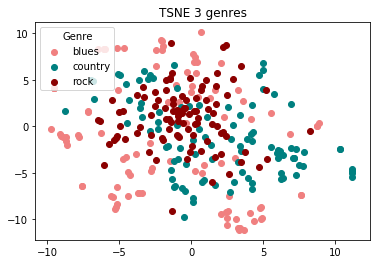

In [6]:
Xe= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_norm)
fig,ax=plt.subplots()
ax.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="blues")
ax.scatter(Xe[target==2,0],Xe[target==2,1],c="teal",label="country")
ax.scatter(Xe[target==3,0],Xe[target==3,1],c="darkred",label="rock")
plt.legend(loc='upper left',title="Genre")
plt.title('TSNE 3 genres')
plt.show()

In [7]:
# Splitting the data into train/test/validation
X_train, X_test, y_train, y_test = train_test_split(X_complete, target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

check_test = X_test[:,-1]
X_train,X_test,X_val = X_train[:,:-1],X_test[:,:-1],X_val[:,:-1]

In [8]:
# Applying the dimensionality reduction via Barnes-Hut tsne
Xe_test= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_test)
Results = np.empty((6,3), dtype='object')

## Classifiers

### Logistic Regression

In [9]:
logistic = LogisticRegression(max_iter = 100000)
logistic.fit(X_train,y_train)

LogisticRegression(max_iter=100000)

Error train: 8.333333333333337 %
Error test: 26.66666666666667 %
Songs that were wrong labeled: [124.0, 214.0, 107.0, 74.0, 276.0, 300.0, 59.0, 79.0, 221.0, 140.0, 249.0, 52.0, 89.0, 222.0, 1.0, 181.0]


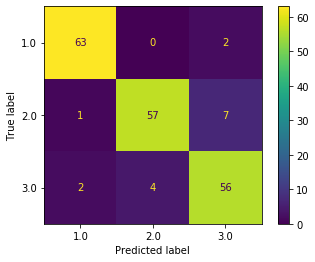

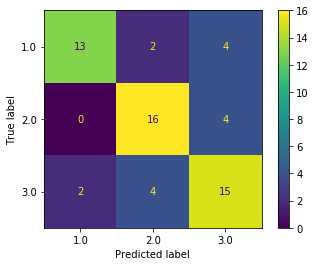

In [10]:
plot_confusion_matrix(logistic,X_train,y_train)
err = np.sum(logistic.predict(X_train) == y_train)/len(y_train)
Results[0,0]=str((1-err)*100)+"%"
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(logistic,X_test,y_test)
err = np.sum(logistic.predict(X_test) == y_test)/len(y_test)
Results[0,1]=str((1-err)*100)+"%"
print("Error test:",(1-err)*100,"%")

pred = logistic.predict(X_test)
wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",wrong_songs)

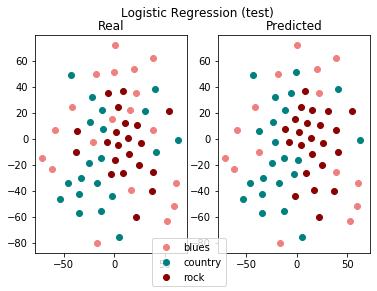

In [11]:
plotgenres(Xe_test,y_test,pred,"Logistic Regression (test)")

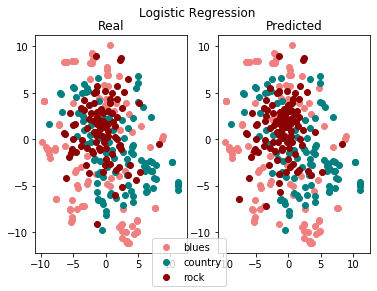

In [12]:
pred = logistic.predict(X_norm)
plotgenres(Xe,target,pred,"Logistic Regression")

## Decision Tree

In [13]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

Error train: 7.2916666666666625 %
Error test: 43.333333333333336 %


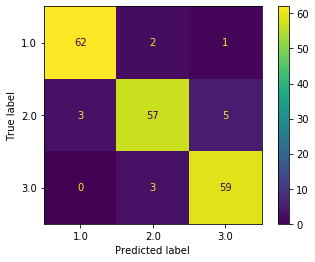

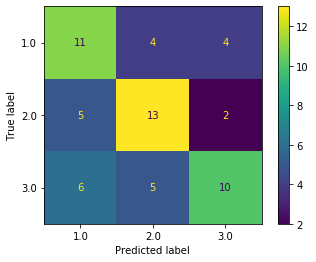

In [14]:
plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
Results[1,0]=str((1-err)*100)+"%"
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
Results[1,1]=str((1-err)*100)+"%"
print("Error test:",(1-err)*100,"%")

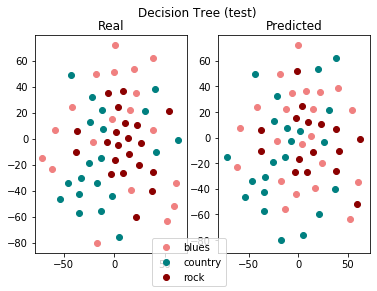

In [15]:
pred = clf.predict(X_test)
plotgenres(Xe_test,y_test,pred,"Decision Tree (test)")

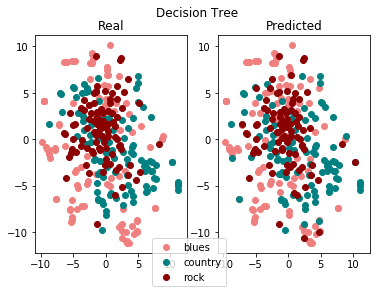

In [16]:
pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"Decision Tree")

## Support vector machine

Kernels:
* Lineal
* Polynomial
* Radial base

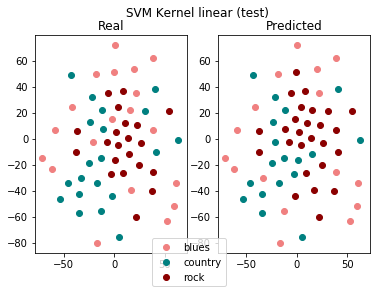

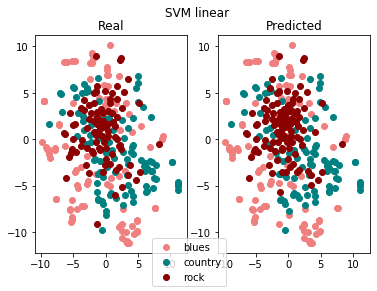

In [17]:
parameters = {'C':[0.1,0.01,1,10]}
linear_kernel_svm_clf = svm.SVC(kernel = "linear")
clf = GridSearchCV(linear_kernel_svm_clf, parameters)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
plotgenres(Xe_test,y_test,pred,"SVM Kernel linear (test)")

pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"SVM linear")

{'C': 1}
Accuracy: 0.6066666666666667
Error train: 7.8125 %
Error test: 26.66666666666667 %
Songs that were wrong labeled: [190.0, 124.0, 214.0, 107.0, 74.0, 59.0, 79.0, 168.0, 221.0, 140.0, 52.0, 89.0, 222.0, 229.0, 1.0, 181.0]


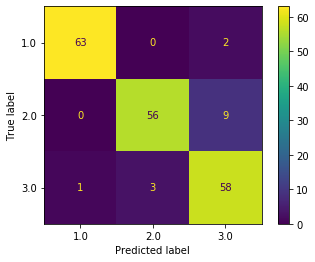

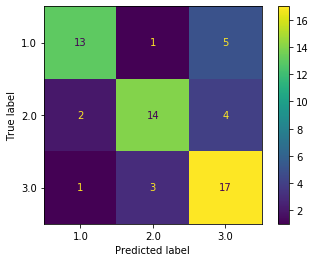

In [18]:
print(clf.best_params_)
cross_scores = cross_val_score(clf, X_norm, target, cv=10)
Results[2,2]=clf.best_params_
print("Accuracy:" ,cross_scores.mean())

plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
Results[2,0]=str((1-err)*100)+"%"
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
Results[2,1]=str((1-err)*100)+"%"
print("Error test:",(1-err)*100,"%")

pred = clf.predict(X_test)
wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",wrong_songs)

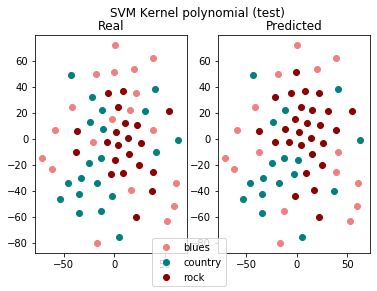

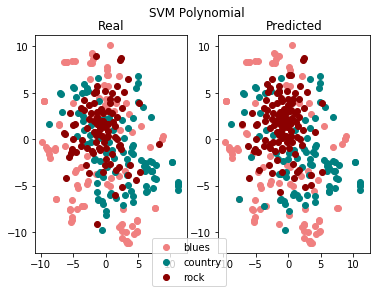

In [19]:
parameters = {'degree':[2,3,4,5,6,7,8,9,10], 'C':[0.1,0.01,1,10]}
poly_kernel_svm_clf = svm.SVC(kernel = "poly")
clf = GridSearchCV(poly_kernel_svm_clf, parameters)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
plotgenres(Xe_test,y_test,pred,"SVM Kernel polynomial (test)")

pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"SVM Polynomial")

{'C': 0.1, 'degree': 2}
Accuracy: 0.6200000000000001
Error train: 14.583333333333337 %
Error test: 30.000000000000004 %
Songs that were wrong labeled: [124.0, 214.0, 107.0, 74.0, 276.0, 59.0, 79.0, 168.0, 221.0, 140.0, 52.0, 89.0, 81.0, 222.0, 1.0, 176.0, 181.0, 215.0]


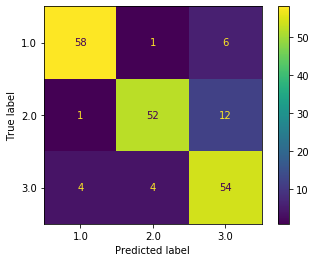

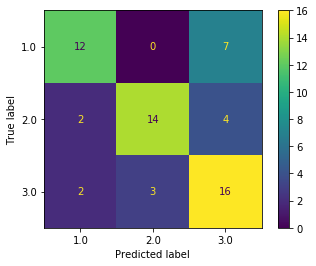

In [20]:
print(clf.best_params_)
cross_scores = cross_val_score(clf, X_norm, target, cv=10)
Results[3,2]=clf.best_params_
print("Accuracy:" ,cross_scores.mean())

plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
Results[3,0]=str((1-err)*100)+"%"
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
Results[3,1]=str((1-err)*100)+"%"
print("Error test:",(1-err)*100,"%")

pred = clf.predict(X_test)
wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",wrong_songs)

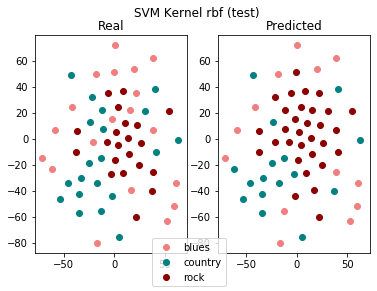

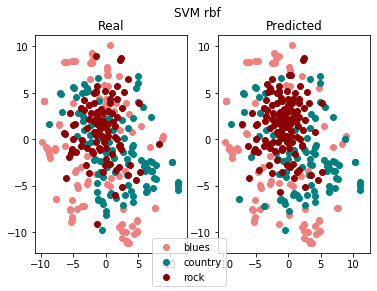

In [21]:
parameters = {'gamma':[0.001,0.01,0.1,1,10], 'C':[0.1,0.01,1,10]}
rbf_kernel_svm_clf = svm.SVC(kernel = "rbf",gamma=30,C=10)
clf = GridSearchCV(rbf_kernel_svm_clf, parameters)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
plotgenres(Xe_test,y_test,pred,"SVM Kernel rbf (test)")

pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"SVM rbf")

{'C': 10, 'gamma': 0.01}
Accuracy: 0.6166666666666666
Error train: 15.625 %
Error test: 30.000000000000004 %
Songs that were wrong labeled: [124.0, 214.0, 107.0, 74.0, 59.0, 79.0, 168.0, 106.0, 91.0, 140.0, 52.0, 89.0, 81.0, 222.0, 1.0, 176.0, 181.0, 215.0]


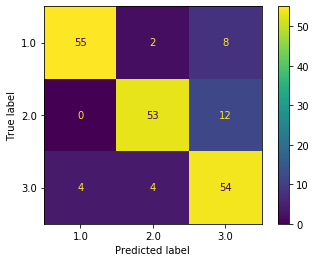

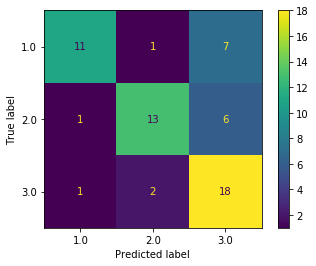

In [22]:
print(clf.best_params_)
cross_scores = cross_val_score(clf, X_norm, target, cv=10)
Results[2,2]=clf.best_params_
print("Accuracy:" ,cross_scores.mean())

plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
Results[4,0]=str((1-err)*100)+"%"
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
Results[4,1]=str((1-err)*100)+"%"
print("Error test:",(1-err)*100,"%")

pred = clf.predict(X_test)
wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",wrong_songs)

## Multilayer Perceptron

* Hidden layers: $L = 1,...,3$
* Number of neurons in the hidden layers: $l_i = 1,2,3$
* Learning rate: 0.2,0.5,0.9

In [23]:
parameters = {
    #'hidden_layer_sizes': [(368,), (555,), (100,)],
    'activation': ['identity', 'logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    #'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': [0.002,0.005,0.009,0.008,0.0002,0.0005,0.0009,0.0008]
    #'max_iter': [200, 1000, 5000, 10000]
}
nn =  MLPClassifier(hidden_layer_sizes=(100,100,100,100,100))
clf = GridSearchCV(nn, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100,
                                                         100)),
             param_grid={'activation': ['identity', 'logistic', 'relu'],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.002, 0.005, 0.009, 0.008,
                                                0.0002, 0.0005, 0.0009,
                                                0.0008],
                         'solver': ['sgd', 'adam']})

{'activation': 'relu', 'learning_rate': 'adaptive', 'learning_rate_init': 0.008, 'solver': 'sgd'}
Error train: 10.9375 %
Error test: 30.000000000000004 %
Songs that were wrong labeled: [124.0, 214.0, 107.0, 74.0, 59.0, 79.0, 168.0, 91.0, 140.0, 249.0, 52.0, 89.0, 222.0, 229.0, 223.0, 1.0, 285.0, 181.0]


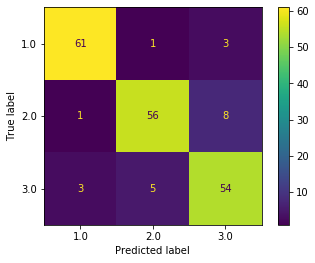

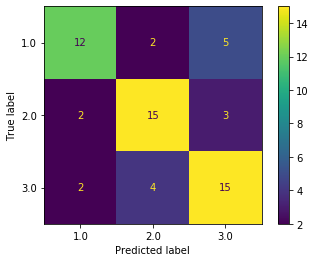

In [24]:
print(clf.best_params_)
Results[5,2]=clf.best_params_

plot_confusion_matrix(clf,X_train,y_train)
err = np.sum(clf.predict(X_train) == y_train)/len(y_train)
Results[5,0]=str((1-err)*100)+"%"
print("Error train:",(1-err)*100,"%")

plot_confusion_matrix(clf,X_test,y_test)
err = np.sum(clf.predict(X_test) == y_test)/len(y_test)
Results[5,1]=str((1-err)*100)+"%"
print("Error test:",(1-err)*100,"%")

pred = clf.predict(X_test)
wrong_songs = wrong_predictions(pred,y_test,check_test)
print("Songs that were wrong labeled:",wrong_songs)

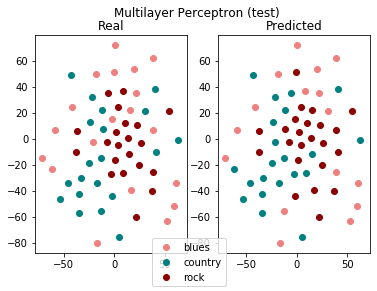

In [25]:
plotgenres(Xe_test,y_test,pred,"Multilayer Perceptron (test)")

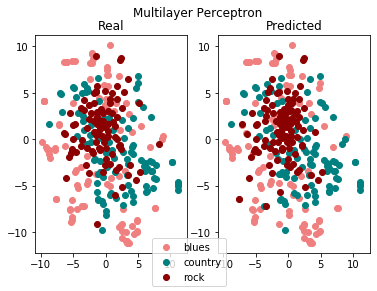

In [28]:
pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"Multilayer Perceptron")
#print(clf.loss_)

In [29]:
pd.DataFrame(data=Results, index=["Logistic Regression", "Decision Tree","SVM linear kernel","SVM polynomial kernel","SVM rbf kernel","Multilayer Perceptorn"], columns=["Error train","Error test","Parameters"])

,Error train,Error test,Parameters
Logistic Regression,8.333333333333337%,26.66666666666667%,None
Decision Tree,7.2916666666666625%,43.333333333333336%,None
SVM linear kernel,7.8125%,26.66666666666667%,"{'C': 10, 'gamma': 0.01}"
SVM polynomial kernel,14.583333333333337%,30.000000000000004%,"{'C': 0.1, 'degree': 2}"
SVM rbf kernel,15.625%,30.000000000000004%,None
Multilayer Perceptorn,10.9375%,30.000000000000004%,"{'activation': 'relu', 'learning_rate': 'adapt..."
